# Functions and imports

In [1]:
%reload_ext autoreload
%autoreload 2

from copy import deepcopy
from datetime import datetime, timedelta
from file_exchange import config, network
from file_exchange.network import Network
from file_exchange.peers_view import PeersView
from file_exchange.user import User
from gevent.event import AsyncResult
from gevent.pool import Group
from gevent.select import select
import gevent
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import seaborn as sns
import shutil
import sys
import time
import traceback

def get_users_pair(users):
    u1 = random.choice(users)
    u2 = random.choice(users)
    while u1 == u2:
        u2 = random.choice(users)
    return u1, u2

def save_conf(conf):
    with open(conf['output_dir']+"conf.json", "w") as f:
        conf2 = deepcopy(conf)
        conf2['period'] = str(conf2['period'])
        json.dump(conf2, f)
def load_conf(path):
    f = open(path+'conf.json', 'r')
    conf = json.load(f)
    conf['period'] = datetime.strptime(conf['period'], "%H:%M:%S") - \
                      datetime.strptime("00:00", "%H:%M")
    return conf        

def init_dir(path):
    if path is None:
        return
    if os.path.isdir(path):
        if os.listdir(path):
            ans = input("Remove previous content of "+path+"? (y/N) ")
            if ans == 'Y' or ans == 'y' or ans == 'o' or ans == 'O':
                shutil.rmtree(path)
    if not os.path.isdir(path):
        os.makedirs(path)
        
def run_experiment(conf):
    init_dir(conf['output_dir'])

    # Initializing stuff
    address_book = PeersView(conf)
    net = Network()
    users = [None] * conf['n_users']
    for i in range(conf['n_users']):
        users[i] = User(address_book, net, conf)

    # Picking users for file exchange
    users_pairs = set()
    while len(users_pairs) < conf['n_file_exchanges']:
        u1, u2 = get_users_pair(users)
        users_pairs.add((u1, u2))
        print("{} will send a file to {}.".format(
            u1.name, u2.name))

    # Start greenlets
    for u in users:
        u.start()
    

    # Wait a bit for everyone to register to address_book
    #gevent.sleep(conf['period'].total_seconds())
    gevent.sleep(1)
    # Init file exchanges
    files_info=[]
    for i, (u1, u2) in enumerate(users_pairs):
        try:
#             print("#{} Starting file exchange between {} and {}".format(
#                 i, u1.name, u2. name), flush=True)
            file_info = u2.init_file_receive(u1)
            files_info.append(file_info)
        except:
#             print("#{} Failed starting file exchange between {} and {}:".format(
#                 i, u1.name, u2. name), flush=True)
            #traceback.print_exception(*sys.exc_info(), flush=True)
            traceback.print_exc()
            pass
            
    n_file_exchanges = len(files_info)
    
    # Wait for all greenlets to terminate
    # print("Waiting for experiment termination")
    gevent.joinall(users)
    
    files_info = [v  for u in users for _, v in u.sending_files.items()]
    
    # Save config
    if conf['output_dir'] is not None:
        save_conf(conf)
        with open(conf['output_dir']+"files_info.bin", 'wb') as f:
            pickle.dump(files_info, f)

    print("Done")
    return files_info, users

# File sharing

In [ ]:
conf = config.default
conf['n_users'] = 20
conf['n_rounds'] = 20
conf['period'] = timedelta(seconds=5)
conf['do_monitor'] = True
conf['experiment_name'] = "random_connected_w_mess_in_queue"
conf['output_dir'] = 'data/'+conf['experiment_name']+'/'
conf['send_strategy'] = 'random_connected'
conf['n_file_exchanges'] = 2
print(conf)

files_info, users = run_experiment(conf)

{'n_rounds': 20, 'ping_time': 0.1, 'layer_threshold': 0.001, 'n_users': 20, 'output_dir': 'data/random_connected_w_mess_in_queue/', 'n_file_exchanges': 2, 'minimum_node_availability': 0, 'n_layers': 3, 'file_size': 10240, 'gossip_size': 20, 'ack_size': 0, 'chunk_max_size': 128, 'send_strategy': 'random_connected', 'bandwidth': 400, 'experiment_name': 'random_connected_w_mess_in_queue', 'header_size': 100, 'period': datetime.timedelta(0, 5), 'do_monitor': True, 'n_file_chunks': 10}
Remove previous content of data/random_connected_w_mess_in_queue/? (y/N) y
Delilah will send a file to Delaine.
Delaine will send a file to Many.
Device hzg3crlk89wp (owned by Delilah) will send file votjj4
Device pvpn0zdg9haw (owned by Delaine) will send file 0u7cf9


In [3]:
files_info = [v  for u in users for _, v in u.sending_files.items()]
[file_info['f'].shared_chunks for file_info in files_info]

[array([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2], dtype=uint64),
 array([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 4,
        3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1], dtype=uint64)]

# Interpretation

In [18]:
def fetch_dataframes(conf):
    devices_df = pd.DataFrame()
    users_df = pd.DataFrame()
    for fn in os.listdir(conf['output_dir']):
        if not fn.endswith(".csv"):
            continue
            
        filepath = conf['output_dir']+fn
        if re.search("device", fn):
            devices_df = append_to_df(filepath, devices_df)
        elif re.search("user", fn):
            users_df = append_to_df(filepath, users_df)

    devices_df['t'] -= min(devices_df['t'])
    devices_df = devices_df.sort_values('t')
    users_df['t'] -= min(users_df['t'])
    users_df = users_df.sort_values('t')
    return devices_df, users_df

def fetch_experiment_data(path):
    conf = load_conf(path)
    with open(conf['output_dir']+"files_info.bin", 'rb') as f:
        files_info = pickle.load(f)
    devices_df, users_df = fetch_dataframes(conf)  
    return conf, files_info, devices_df, users_df

def append_to_df(filepath, df):
    try:
        df2 = pd.read_csv(filepath)
    except:
        print("Failed loading {}: {}".format(fn, sys.exc_info()))
        pass
    else:
        if(df.empty):
            df = df2
        else:
            df = df.append(df2,)
    return df

conf, files_info, devices_df, users_df = fetch_experiment_data("data/file_exchange_random_connected/")

## Plot traffic

In [24]:
files_id = np.unique(devices_df['file_id'])
n_files = len(files_id)
# BINS = conf['n_rounds']
# x = np.linspace(0, max(devices_df['t'])+.0001, num=BINS)
MAX_TIME = math.ceil(max(devices_df['t']))

y = np.zeros((n_files, MAX_TIME-1), dtype=np.float64)
for i, f_id in enumerate(files_id):
    df = devices_df[devices_df['file_id'] == f_id]
    for t in range(0, MAX_TIME-1):
        df2 = df[(df['t'] >= t) & (df['t'] < t+1)]
        y[i, t] = df2['sent'].sum() + df2['forwarded'].sum()
        
y

array([[ 684.,  684., 2024., 1212., 1568., 1312., 1240., 2424., 1712.,
        1640.,  628.,  628.,  500.,    0.,    0.,    0.,    0.,    0.,
           0.,  684.,  456., 1696., 1340., 1668., 1768., 1940., 1440.,
        1968., 1112.,  784., 2452.,  984., 1996., 1240., 1540., 1896.,
         984., 2280., 1768., 1868., 1340., 1896., 1212., 1440., 1312.,
        1568., 2096.,  984., 2296., 2196., 2852., 2168., 2168., 2040.,
        2012., 1968., 1812., 1540., 1240., 1112., 1056.,  984.,  656.,
         728.,  428.,  728.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         684.,  912., 1368., 1368.,  912., 1824.,  912., 1596., 1140.,
        1596.,  784.,  756.,  628.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  684.,  684., 1012., 2324., 1412., 1568., 1740.,
      

In [6]:
devices_df

,t,addr,owner,current_round,file_id,chunk_id,mess_id,type,sent,received,forwarded,success
0,0.000000,y3i6b24bqbe2,Toshiko,0,d1wh07,62,3289435750,1,228,0,0,True
0,0.003808,7gpkdt64bjiq,Brande,0,3n1k98,68,3576202853,1,228,0,0,True
0,0.680131,e01hwvoj82h0,Barry,0,d1wh07,62,3289435750,1,0,0,228,True
0,0.684192,rxp95lpzkixr,Demetra,0,3n1k98,68,3576202853,1,0,0,228,True
1,0.687829,y3i6b24bqbe2,Toshiko,0,d1wh07,57,3482480954,1,228,0,0,True
1,0.692228,7gpkdt64bjiq,Brande,0,3n1k98,52,3817872290,1,228,0,0,True
0,1.374316,ajb7ly56be7c,Bronwyn,0,d1wh07,57,3482480954,1,0,0,228,True
0,1.378714,t116wamzv3d8,Bronwyn,0,3n1k98,68,3576202853,1,0,0,228,True
0,1.382367,83zvb4oz95iq,Norene,0,d1wh07,62,3289435750,1,0,0,228,True
0,1.385967,6mikqz05kuek,Janetta,0,3n1k98,52,3817872290,1,0,0,228,True


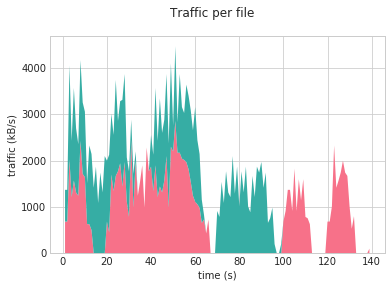

In [39]:
sns.set_style('whitegrid')
f, ax = plt.subplots()

ax.stackplot(range(1, MAX_TIME), y, colors=sns.color_palette("husl", n_colors=n_files))

ax.set_xlabel('time (s)')
ax.set_ylabel('traffic (kB/s)')
plt.suptitle("Traffic per file")

plt.savefig("outputs/"+conf['experiment_name']+'/traffic_per_file.svg')
plt.show()

### Messages' RTT

In [11]:
messages_id = np.unique(devices_df['mess_id'])
transfer_times = np.zeros(len(messages_id), dtype=np.float64)

for i, m_id in enumerate(messages_id):
    data = devices_df[devices_df['mess_id'] == m_id]['t']
    transfer_times[i] = max(data) - min(data)
    
transfer_times.sort()

[6.204317944007926,
 3.6222212180146016,
 2.2127006930240896,
 0.7418729999917559,
 3.4601653560239356,
 3.44919604001916,
 2.079189755982952,
 0.36460354301379994,
 2.050487050000811,
 1.453256760025397,
 3.7919266120006796,
 2.057422931015026,
 2.0578835050109774,
 2.183734300022479,
 0.3814096940041054,
 3.4540534400148317,
 1.126895440975204,
 2.4187647370272316,
 2.1759433380211703,
 1.1505219540267717,
 3.477960254997015,
 1.4774777360144071,
 2.0611345669894945,
 2.1049150610051583,
 2.146729101979872,
 2.064027835993329,
 2.122329570003785,
 13.119862821011338,
 5.4248022609972395,
 1.7095168409869075,
 1.0298061670036986,
 14.835763946000952,
 12.534681252000155,
 2.7923317000095267,
 2.4060270420159213,
 2.454286101012258,
 0.37129327197908424,
 2.4050006050092634,
 1.5688459270168096,
 1.7100866249820683,
 3.095072219002759,
 0.37052782101091,
 1.0378815539879724,
 3.5934694810130168,
 2.4320780819980428,
 1.1960286130197346,
 2.0955484609876294,
 0.40015640898491256,
 12.13

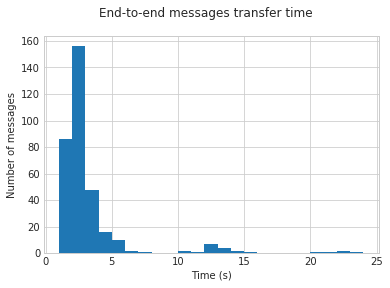

In [35]:
f, ax = plt.subplots()

ax.hist(transfer_times, bins=range(1, math.ceil(max(transfer_times))))

ax.set_xlabel('Time (s)')
ax.set_ylabel('Number of messages')
plt.suptitle('Messages round trip time cumulative dist. function')

plt.savefig("outputs/"+conf['experiment_name']+'/messages_transfer_time.svg')
plt.show()

### Messages error rate

In [41]:
devices_df[devices_df['success'] == False]

,t,addr,owner,current_round,file_id,chunk_id,mess_id,type,sent,received,forwarded,success
36,100.718705,83zvb4oz95iq,Norene,10,3n1k98,7,1714995071,1,0,0,228,False
7,101.397635,72goapsnmkhu,Angelita,10,3n1k98,21,1869603098,1,0,0,228,False
23,102.109657,i7a0qgwkrdzt,Barry,10,3n1k98,17,639365050,1,0,0,228,False
37,102.798277,83zvb4oz95iq,Norene,10,3n1k98,16,3456101644,1,0,0,228,False
38,103.488188,83zvb4oz95iq,Norene,10,3n1k98,19,2845912222,1,0,0,228,False
24,104.170444,i7a0qgwkrdzt,Barry,10,3n1k98,55,266581675,1,0,0,228,False
40,104.871650,68mnbczxzbpa,Kaci,10,3n1k98,22,3119339790,1,0,0,228,False
80,105.570979,todsfshih476,Angelita,10,3n1k98,76,2635762523,1,0,0,228,False
8,106.248691,72goapsnmkhu,Angelita,10,3n1k98,62,2058674697,1,0,0,228,False
83,107.644755,todsfshih476,Angelita,10,3n1k98,55,197850795,1,0,0,228,False
